In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
# Importamos matplotlib para visualizaciones
import matplotlib.pyplot as plt

In [38]:
# Only if the notebook is being executed in Colab

# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
# df=pd.read_csv('Cleaned_DS_Jobs.csv')

df = pd\
   .read_csv('Cleaned_DS_Jobs.csv')
#             sep = ',',
#             index_col=[0])

## 1. ¿Hay variables con missing values? Presenta un gráfico con las variables que tienen missing

Columnas con missing: 0


,missing_count,missing_pct


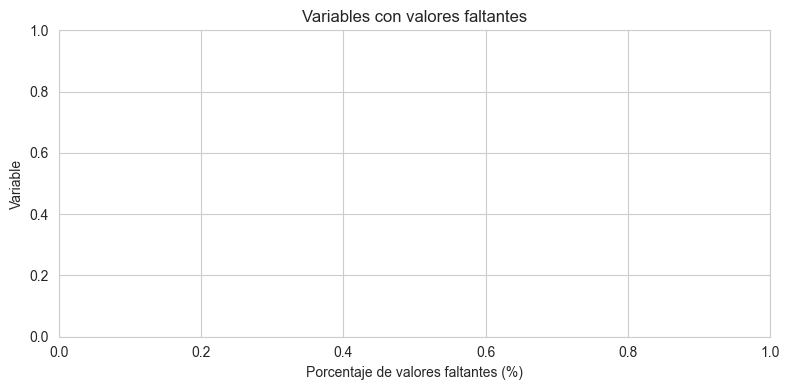

In [40]:
# 1) Calcular el número de valores faltantes por columna
valores_nan = df.isna().sum()

# 2) Calcular el porcentaje de valores faltantes por columna (más útil para comparar)
porcentaje_nan = (df.isna().mean() * 100).round(2)

# 3) Unir ambos en un DataFrame y ordenar por porcentaje descendente
missing = pd.concat([valores_nan, porcentaje_nan], axis=1)
missing.columns = ['missing_count', 'missing_pct']
missing = missing[missing['missing_count'] > 0].sort_values('missing_pct', ascending=False)


print(f"Columnas con missing: {len(missing)}")
display(missing)

# 4) Gráfico: barras horizontales con el porcentaje de missing por variable
sns.set_style('whitegrid')
plt.figure(figsize=(8, max(4, 0.5 * len(missing))))  # ajustar altura según nº de variables
plot_df = missing.reset_index().rename(columns={'index': 'variable'})
ax = sns.barplot(x='missing_pct', y='variable', data=plot_df, palette='rocket')

# Etiquetas y título
ax.set_xlabel('Porcentaje de valores faltantes (%)')
ax.set_ylabel('Variable')
ax.set_title('Variables con valores faltantes')

# Anotar valores exactos al final de cada barra
for i, v in enumerate(plot_df['missing_pct']):
    ax.text(v + 0.5, i, f"{v:.2f}%", va='center')

plt.tight_layout()
plt.show()

## 2. ¿Cual es la distribución del salario que se ofrece en los puestos del dataframe?

Columna de salario usada: Salary Estimate


count    660.000000
mean     123.799242
std       39.771639
min       43.500000
25%      103.000000
50%      114.000000
75%      136.500000
max      271.500000
Name: Salary Estimate, dtype: float64

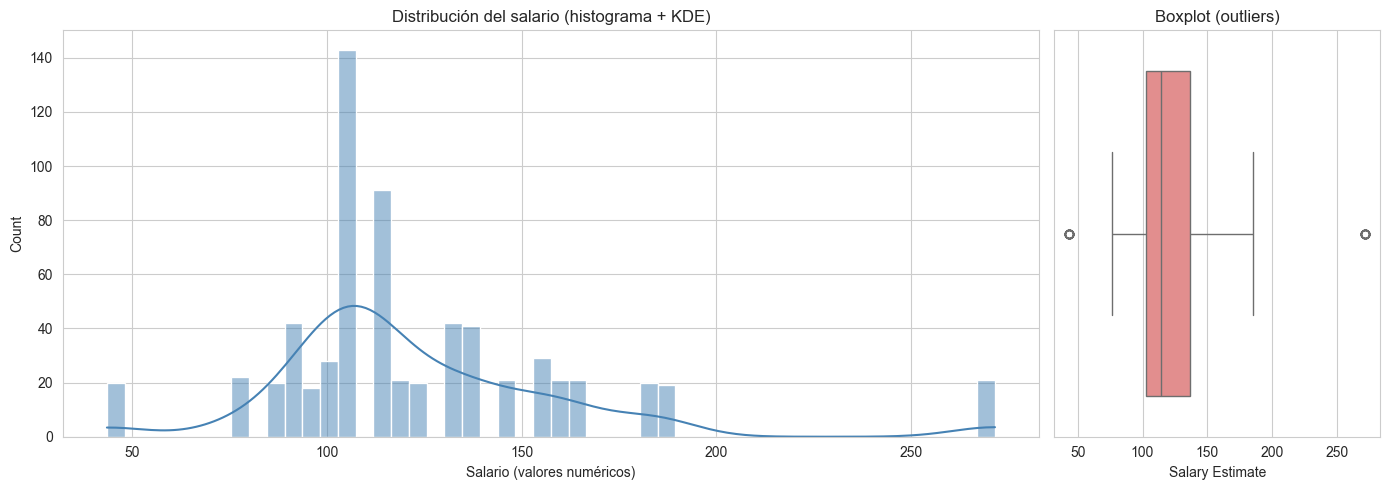

Percentiles: 10%=92.50, 25%=103.00, 50%=114.00, 75%=136.50, 90%=164.50


In [41]:
# Detectar columna de salario por nombres comunes
candidates = [c for c in df.columns if any(k in c.lower() for k in ('sal', 'salary', 'salario', 'sueldo', 'pay', 'comp'))]
salary_col = candidates[0] if candidates else None

if salary_col is None:
    print("No se detectó columna de salario por nombre. Indica el nombre de la columna de salario.")
else:
    s = df[salary_col]

    # Función para parsear salario SIN usar expresiones regulares.
    def parse_salary_no_regex(x):
        if pd.isna(x):
            return np.nan
        text = str(x).lower().strip()

        # eliminar símbolos y palabras comunes de moneda
        for token in ['€', '$', 'usd', 'eur', '€', '£', 'mxn', 'cop', '\u20ac']:
            text = text.replace(token, '')
        text = text.replace(',', '')  # quitar separadores de miles

        # manejar rangos escritos con '-' o ' to '
        if '-' in text or ' to ' in text:
            # normalizar separador y dividir
            parts = text.replace('–', '-').replace(' to ', '-').split('-')
            vals = []
            for p in parts:
                p = p.strip()
                if not p:
                    continue
                mult = 1
                if p.endswith('k'):
                    mult = 1_000
                    p = p[:-1].strip()
                elif p.endswith('m'):
                    mult = 1_000_000
                    p = p[:-1].strip()
                # extraer sólo dígitos y punto
                cleaned = ''.join(ch for ch in p if (ch.isdigit() or ch == '.'))
                if cleaned == '':
                    continue
                try:
                    vals.append(float(cleaned) * mult)
                except:
                    continue
            return np.mean(vals) if vals else np.nan

        # si hay sufijo k/m en el número (ej. "50k")
        mult = 1
        if text.endswith('k'):
            mult = 1_000
            text = text[:-1].strip()
        elif text.endswith('m'):
            mult = 1_000_000
            text = text[:-1].strip()

        # mantener sólo dígitos y punto
        cleaned = ''.join(ch for ch in text if (ch.isdigit() or ch == '.'))
        if cleaned == '':
            return np.nan
        try:
            return float(cleaned) * mult
        except:
            return np.nan

    # aplicar la función y convertir a float
    if pd.api.types.is_numeric_dtype(s):
        salary_numeric = s.astype(float)
    else:
        salary_numeric = s.map(parse_salary_no_regex).astype(float)

    salary_clean = salary_numeric.dropna()
    if salary_clean.empty:
        print("No se han podido obtener valores numéricos de salario a partir de la columna seleccionada.")
    else:
        # estadísticos y visualización (histograma + boxplot)
        print(f"Columna de salario usada: {salary_col}")
        display(salary_clean.describe(percentiles=[.25, .5, .75]))

        sns.set_style('whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(14,5), gridspec_kw={'width_ratios':[3,1]})
        sns.histplot(salary_clean, kde=True, bins=50, ax=axes[0], color='steelblue')
        axes[0].set_title('Distribución del salario (histograma + KDE)')
        axes[0].set_xlabel('Salario (valores numéricos)')
        sns.boxplot(x=salary_clean, ax=axes[1], color='lightcoral', orient='h')
        axes[1].set_title('Boxplot (outliers)')
        plt.tight_layout()
        plt.show()

        # percentiles relevantes
        p10, p25, p50, p75, p90 = np.percentile(salary_clean, [10,25,50,75,90])
        print(f"Percentiles: 10%={p10:.2f}, 25%={p25:.2f}, 50%={p50:.2f}, 75%={p75:.2f}, 90%={p90:.2f}")

## 3. ¿Cual es la posición que más ofertas de trabajo tiene?

,count,pct_of_total
job_simp,,
data scientist,447,67.73
na,68,10.30
analyst,55,8.33
data engineer,46,6.97
mle,34,5.15
manager,7,1.06
director,3,0.45


La posición con más ofertas es: 'data scientist' — 447.0 ofertas (67.73% del total)


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/563077847.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top['count'], y=top.index, palette='viridis')


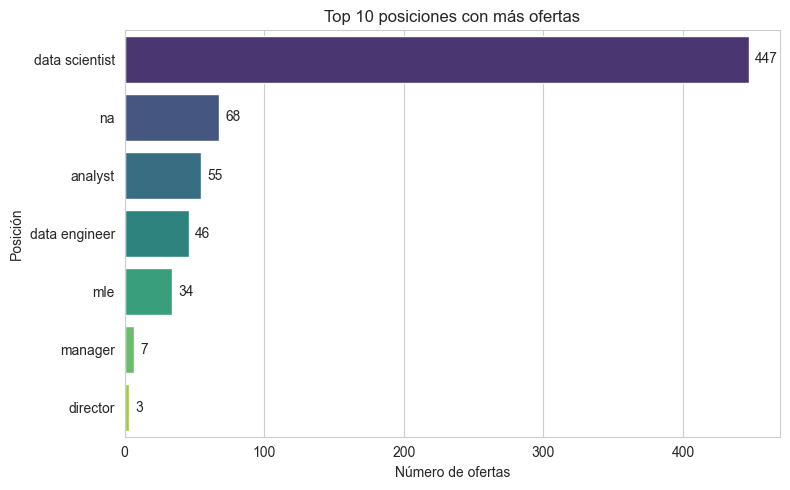

In [42]:
# 1) Elegir la columna más adecuada para el puesto (preferir 'job_simp' si existe)
title_col = 'job_simp'

# 2) Limpiar valores: eliminar espacios sobrantes y normalizar mayúsculas para contar correctamente
titles = df[title_col].astype(str).str.strip()
titles_nonnull = titles.replace({'nan': None}).dropna()

# 3) Contar ocurrencias y calcular porcentajes
counts = titles_nonnull.value_counts()
pct = (counts / len(df) * 100).round(2)
summary = pd.concat([counts, pct], axis=1)
summary.columns = ['count', 'pct_of_total']

# 4) Mostrar los top 10 y el más frecuente
top_n = 10
top = summary.head(top_n)
display(top)

most_common = summary.index[0]
most_count = summary.iloc[0]['count']
most_pct = summary.iloc[0]['pct_of_total']
print(f"La posición con más ofertas es: '{most_common}' — {most_count} ofertas ({most_pct}% del total)")

# 5) Gráfico de barras horizontales para los top N puestos
sns.set_style('whitegrid')
plt.figure(figsize=(8, max(4, 0.5 * top_n)))
ax = sns.barplot(x=top['count'], y=top.index, palette='viridis')
ax.set_xlabel('Número de ofertas')
ax.set_ylabel('Posición')
ax.set_title(f'Top {top_n} posiciones con más ofertas')

# Anotar conteos al final de cada barra
for i, v in enumerate(top['count']):
    ax.text(v + max(1, 0.01 * counts.max()), i, f"{int(v)}", va='center')

plt.tight_layout()
plt.show()

## 4. Si tuvieramos que elegir la posición por el salario, en que posición se ganaria más por termino medio?

Mostrando top 6 posiciones ordenadas por salario medio (columna usada: 'job_simp'):


,count,mean_salary,median_salary
job_simp,,,
manager,7,137.86,114.0
na,68,127.09,115.0
data scientist,447,125.27,114.0
mle,34,118.06,110.0
analyst,55,115.53,107.0
data engineer,46,113.78,113.5


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/668831145.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_salary', y=top.index, data=top.reset_index(), palette='mako')


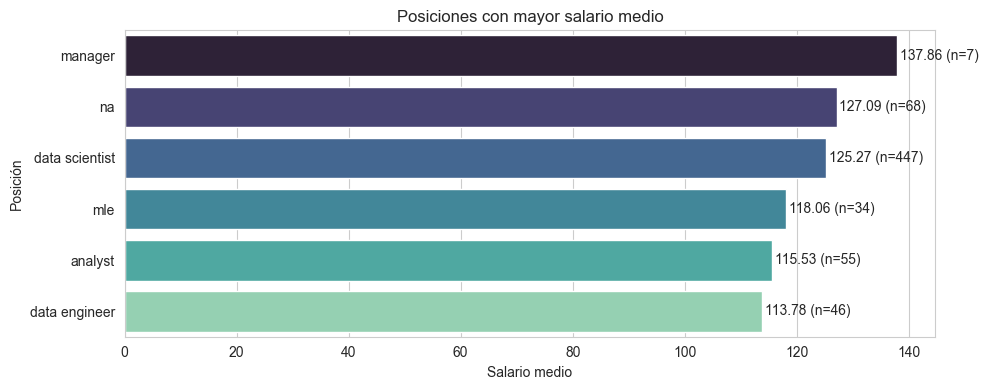

La posición con mayor salario medio es 'manager' con un salario medio de 137.86 (n=7 ofertas).


In [43]:
# 1) Seleccionar columna de título preferida
title_col = 'job_simp'

# 2) Construir serie de salario numérica: priorizar avg_salary, sino usar mean(min,max)
salary = pd.to_numeric(df['avg_salary'], errors='coerce')

# 3) Añadir salario al dataframe temporal y limpiar
temp = df[[title_col]].copy()
temp['salary'] = salary
temp = temp.dropna(subset=['salary', title_col])
temp[title_col] = temp[title_col].astype(str).str.strip()

if temp.empty:
    print("No hay datos numéricos de salario disponibles para agrupar por puesto.")
else:
    # 4) Agrupar por puesto y calcular medias, medianas y conteo
    agg = temp.groupby(title_col)['salary'].agg(['count', 'mean', 'median']).rename(columns={'mean':'mean_salary','median':'median_salary'})
    agg = agg.sort_values('mean_salary', ascending=False)

    # 5) Mostrar top (filtrar por un mínimo de ocurrencias para evitar posiciones con 1 sola oferta)
    min_count = 5
    top_n = 10
    agg_filtered = agg[agg['count'] >= min_count]
    top = agg_filtered.head(top_n)

    if top.empty:
        # si no hay suficientes con min_count, mostrar top sin filtro
        top = agg.head(top_n)
        print(f"No hay posiciones con >= {min_count} ofertas; muestro top {top_n} sin filtrar.")

    print(f"Mostrando top {len(top)} posiciones ordenadas por salario medio (columna usada: '{title_col}'):")
    display(top.round(2))

    # 6) Gráfico: barras horizontales del salario medio
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, max(4, 0.6 * len(top))))
    ax = sns.barplot(x='mean_salary', y=top.index, data=top.reset_index(), palette='mako')
    ax.set_xlabel('Salario medio')
    ax.set_ylabel('Posición')
    ax.set_title('Posiciones con mayor salario medio')

    # Anotar valores en las barras
    for i, (idx, row) in enumerate(top.iterrows()):
        ax.text(row['mean_salary'] + 0.5, i, f"{row['mean_salary']:.2f} (n={int(row['count'])})", va='center')

    plt.tight_layout()
    plt.show()

    # 7) Imprimir la posición con mayor salario medio
    best = top.iloc[0]
    print(f"La posición con mayor salario medio es '{best.name}' con un salario medio de {best['mean_salary']:.2f} (n={int(best['count'])} ofertas).")

## 5. ¿Qué empresa esta ofreciendo más puestos de trabajo?

Columna usada para empresas: 'Company Name'


,count,pct_of_total
Company Name,,
Maxar Technologies,12,1.82
Hatch Data Inc,12,1.82
Tempus Labs,11,1.67
AstraZeneca,10,1.52
Klaviyo,8,1.21
Autodesk,7,1.06
Phoenix Operations Group,7,1.06
Southwest Research Institute,6,0.91
Novetta,6,0.91


La empresa con más ofertas es: 'Maxar Technologies' — 12 ofertas (1.82% del total)


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/2063468309.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top['count'], y=top.index, palette='cubehelix')


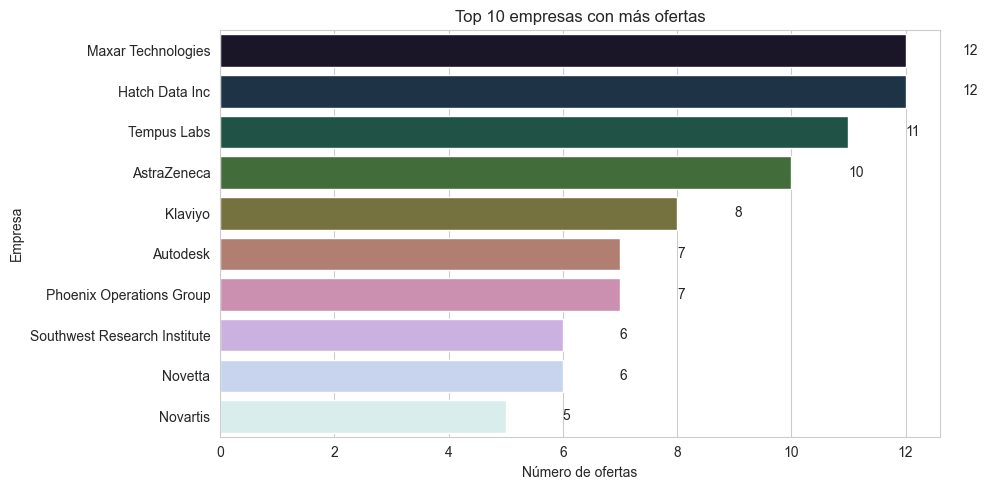

In [44]:
# 1) Elegirir columna de empresa
company_col = 'Company Name' 

# 2) Limpiar y filtrar valores nulos
companies = df[company_col].astype(str).str.strip()
companies = companies.replace({'nan': None, '': None}).dropna()

if companies.empty:
    print("No hay nombres de empresa válidos en la columna seleccionada.")
else:
    # 3) Contar ofertas por empresa y calcular porcentaje
    counts = companies.value_counts()
    pct = (counts / len(df) * 100).round(2)
    summary = pd.concat([counts, pct], axis=1)
    summary.columns = ['count', 'pct_of_total']

    # 4) Mostrar top N empresas
    top_n = 10
    top = summary.head(top_n)
    print(f"Columna usada para empresas: '{company_col}'")
    display(top)

    # 5) Imprimir la empresa con más ofertas
    top_company = counts.index[0]
    top_count = int(counts.iloc[0])
    top_pct = round((top_count / len(df) * 100), 2)
    print(f"La empresa con más ofertas es: '{top_company}' — {top_count} ofertas ({top_pct}% del total)")

    # 6) Gráfico de barras horizontales para las top N empresas
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, max(4, 0.5 * top_n)))
    ax = sns.barplot(x=top['count'], y=top.index, palette='cubehelix')
    ax.set_xlabel('Número de ofertas')
    ax.set_ylabel('Empresa')
    ax.set_title(f'Top {top_n} empresas con más ofertas')

    # Anotar conteos al final de cada barra
    for i, v in enumerate(top['count']):
        ax.text(v + max(1, 0.01 * counts.max()), i, f"{int(v)}", va='center')

    plt.tight_layout()
    plt.show()

## 6. ¿Cuál es la empresa que más valoración tiene?

,count,mean_rating
Company Name,,
Phoenix Operations Group,7,5.0
Klaviyo,8,4.8
GreatAmerica Financial Services,3,4.6
Novetta,6,4.5
Johns Hopkins University Applied Physics Laboratory,3,4.5
Kingfisher Systems,4,4.5
Envision LLC,3,4.5
Systems & Technology Research,3,4.5
Rocket Lawyer,3,4.4


La empresa con mayor valoración media es: 'Phoenix Operations Group' — valoración media 5.00 (n=7)


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/1806724609.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_rating', y=top.index, data=top.reset_index(), palette='viridis')


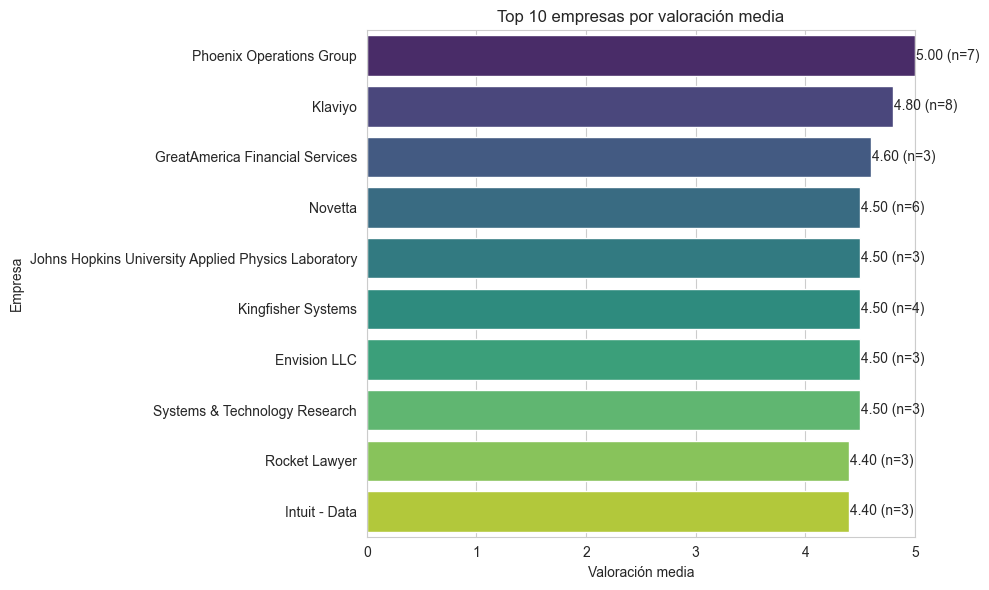

In [45]:
# 1) Selección y limpieza: coger columnas relevantes y convertir rating a numérico.
company_col = 'Company Name'
rating_col = 'Rating'
companies = df[company_col].astype(str).str.strip()
ratings = pd.to_numeric(df[rating_col], errors='coerce')
temp = pd.DataFrame({company_col: companies, rating_col: ratings})
temp = temp.replace({company_col: {'nan': None}}).dropna(subset=[company_col, rating_col])
temp[company_col] = temp[company_col].astype(str).str.strip()

# 2) Agrupación: calcular número de valoraciones y la media por empresa.
agg = temp.groupby(company_col)[rating_col].agg(['count', 'mean']).rename(columns={'mean': 'mean_rating'})

# 3) Filtrado y orden: ordenar por valoración media y filtrar por mínimo de valoraciones para evitar ruido.
agg = agg.sort_values('mean_rating', ascending=False)
min_count = 3
agg_filtered = agg[agg['count'] >= min_count]

# 4) Selección a mostrar: usar el conjunto filtrado si existe, sino mostrar el top general.
top_n = 10
top = agg_filtered.head(top_n) if not agg_filtered.empty else agg.head(top_n)
display(top.round(2))
best = top.iloc[0]
print(f"La empresa con mayor valoración media es: '{top.index[0]}' — valoración media {best['mean_rating']:.2f} (n={int(best['count'])})")

# 5) Visualización: gráfico de barras horizontal con anotaciones de media y conteo.
sns.set_style('whitegrid')
plt.figure(figsize=(10, max(4, 0.6 * len(top))))
ax = sns.barplot(x='mean_rating', y=top.index, data=top.reset_index(), palette='viridis')
ax.set_xlabel('Valoración media')
ax.set_ylabel('Empresa')
ax.set_title(f'Top {len(top)} empresas por valoración media')
for i, (idx, row) in enumerate(top.iterrows()):
    ax.text(row['mean_rating'] + 0.01, i, f"{row['mean_rating']:.2f} (n={int(row['count'])})", va='center')
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

## 7. ¿Que correlación tienen las variables del dataframe? ¿Cuales son las más correladas positivamente? ¿Y negativamente?

Número de columnas numéricas: 13


,Rating,min_salary,max_salary,avg_salary,same_state,company_age,python,excel,hadoop,spark,aws,tableau,big_data
Rating,1.000,-0.059,-0.070,-0.068,0.147,0.102,0.089,-0.027,0.061,-0.030,-0.124,0.009,0.067
min_salary,-0.059,1.000,0.905,0.966,-0.081,-0.043,-0.036,-0.039,0.021,0.033,-0.033,0.013,-0.012
max_salary,-0.070,0.905,1.000,0.984,-0.094,-0.045,-0.002,0.006,0.040,0.006,-0.048,0.034,-0.003
avg_salary,-0.068,0.966,0.984,1.000,-0.091,-0.045,-0.016,-0.013,0.033,0.018,-0.043,0.026,-0.007
same_state,0.147,-0.081,-0.094,-0.091,1.000,-0.021,-0.052,0.040,-0.046,-0.054,-0.015,0.034,-0.087
company_age,0.102,-0.043,-0.045,-0.045,-0.021,1.000,-0.058,0.025,0.069,0.041,-0.007,-0.019,0.014
python,0.089,-0.036,-0.002,-0.016,-0.052,-0.058,1.000,0.031,0.198,0.229,0.174,0.105,0.141
excel,-0.027,-0.039,0.006,-0.013,0.040,0.025,0.031,1.000,0.017,-0.048,0.015,0.182,0.068
hadoop,0.061,0.021,0.040,0.033,-0.046,0.069,0.198,0.017,1.000,0.532,0.190,0.116,0.359
spark,-0.030,0.033,0.006,0.018,-0.054,0.041,0.229,-0.048,0.532,1.000,0.311,0.005,0.322



Top 5 pares más correlados positivamente:


,var1,var2,corr
0,max_salary,avg_salary,0.984
1,avg_salary,max_salary,0.984
2,avg_salary,min_salary,0.966
3,min_salary,avg_salary,0.966
4,min_salary,max_salary,0.905



Top 5 pares más correlados negativamente:


,var1,var2,corr
0,Rating,aws,-0.124
1,aws,Rating,-0.124
2,same_state,max_salary,-0.094
3,max_salary,same_state,-0.094
4,same_state,avg_salary,-0.091


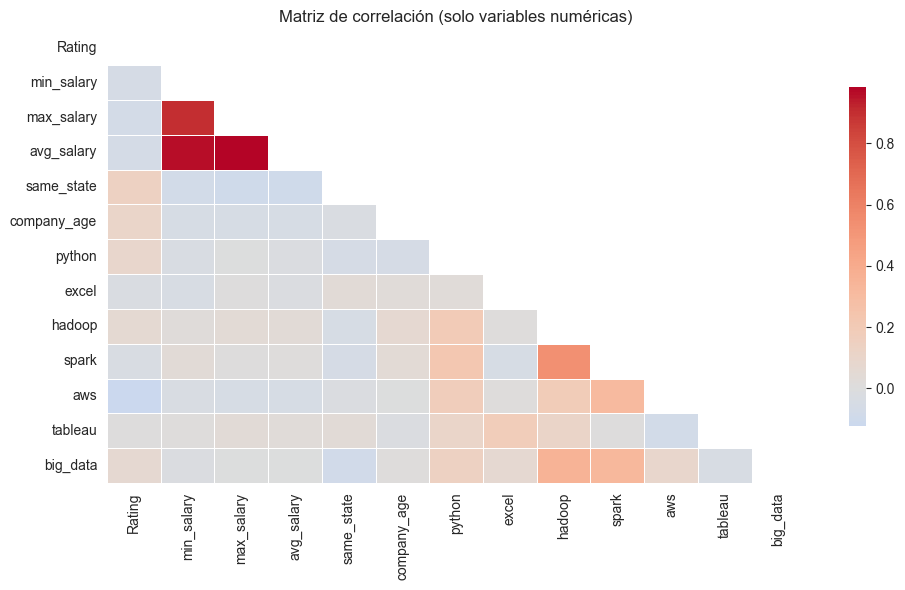


Mayor correlación positiva: max_salary — avg_salary = 0.984
Mayor correlación negativa: Rating — aws = -0.124


In [46]:
# 1) Selección: escoger únicamente las columnas numéricas para calcular correlaciones.
num_df = df.select_dtypes(include=[np.number]).copy()
num_cols = num_df.columns.tolist()

# 2) Cálculo: matriz de correlación (Pearson por defecto).
corr = num_df.corr()

# 3) Presentación rápida: mostrar matrix resumida
print(f"Número de columnas numéricas: {len(num_cols)}")
display(corr.round(3))

# 4) Extracción de pares: obtener pares (i,j) sin duplicados ni auto-correlación
pairs = (
    corr.where(~np.eye(len(corr), dtype=bool))  # eliminar diagonal
        .stack()
        .reset_index()
        .rename(columns={'level_0':'var1','level_1':'var2',0:'corr'})
)

# 5) Ordenar y seleccionar top positivos y negativos
top_k = 5
top_positive = pairs.sort_values('corr', ascending=False).head(top_k)
top_negative = pairs.sort_values('corr', ascending=True).head(top_k)

print(f"\nTop {top_k} pares más correlados positivamente:")
display(top_positive.reset_index(drop=True).round(3))

print(f"\nTop {top_k} pares más correlados negativamente:")
display(top_negative.reset_index(drop=True).round(3))

# 6) Visualización: mapa de calor de la matriz de correlación (enmascarando triángulo superior)
sns.set_style('white')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, max(6, 0.4 * len(num_cols))))
annot = True if len(num_cols) <= 10 else False
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=annot, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .75})
plt.title('Matriz de correlación (solo variables numéricas)')
plt.tight_layout()
plt.show()

# 7) Interpretación corta: imprimir las dos relaciones más fuertes encontradas
if not top_positive.empty:
    vp = top_positive.iloc[0]
    print(f"\nMayor correlación positiva: {vp['var1']} — {vp['var2']} = {vp['corr']:.3f}")
if not top_negative.empty:
    vn = top_negative.iloc[0]
    print(f"Mayor correlación negativa: {vn['var1']} — {vn['var2']} = {vn['corr']:.3f}")


## 8. ¿Cual es la habilidad que más se demanda en los puestos de Data Scientist? ¿y de data Engineer?

Top habilidades (columnas binarias) para Data Scientist:


,skill,count
0,python,358
1,excel,193
2,spark,142
3,aws,119
4,hadoop,109
5,big_data,106
6,tableau,82



Top habilidades (columnas binarias) para Data Engineer:


,skill,count
0,python,38
1,aws,26
2,spark,21
3,excel,20
4,hadoop,19
5,big_data,17
6,tableau,6


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/4028090386.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ds_counts.values, y=ds_counts.index, ax=axes[0], palette='Blues_d')
/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/4028090386.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=de_counts.values, y=de_counts.index, ax=axes[1], palette='Greens_d')


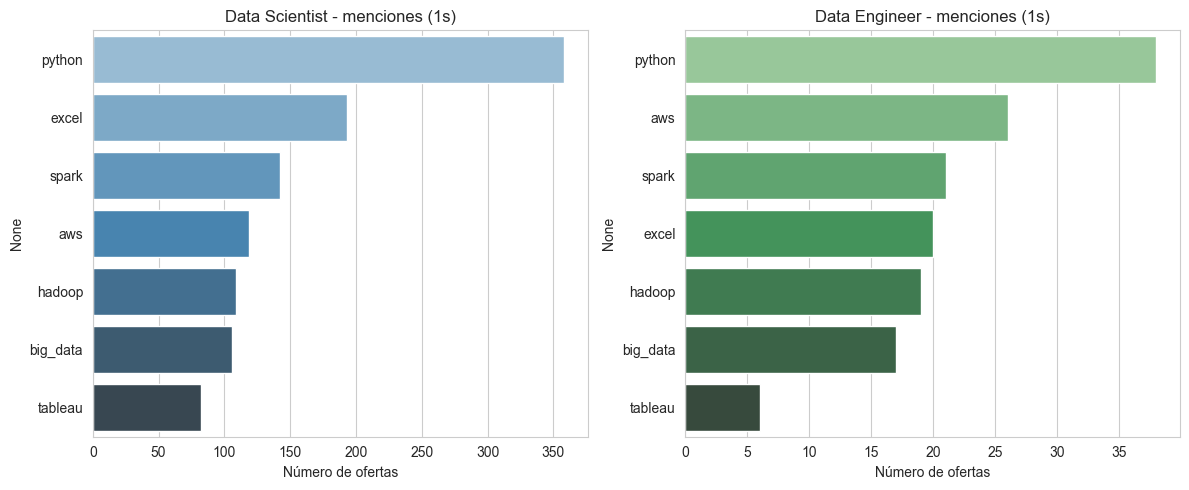

Para Data Scientist: python — 358 ofertas
Para Data Engineer: python — 38 ofertas


In [47]:
# Usar columnas binarias de skills (1/0) en lugar de la columna 'Skills'
title_col = 'job_simp'
# lista de skills esperadas (ajusta si tu CSV tiene otros nombres)
known_skills = ['python','excel','hadoop','spark','aws','tableau','big_data']

# detectar columnas de skill presentes en el df (case-insensitive)
skill_cols = [c for c in df.columns if c.lower() in set(known_skills)]

if not skill_cols:
    print("No se encontraron columnas de skills binarias en el dataframe. Columnas esperadas:", known_skills)
else:
    # filtros de puesto
    ds_mask = df[title_col].astype(str).str.contains('data scientist', case=False, na=False, regex=False)
    de_mask = df[title_col].astype(str).str.contains('data engineer', case=False, na=False, regex=False)

    # sumar 1s por skill para cada grupo
    ds_counts = df.loc[ds_mask, skill_cols].sum().sort_values(ascending=False)
    de_counts = df.loc[de_mask, skill_cols].sum().sort_values(ascending=False)

    top_n = 10
    print("Top habilidades (columnas binarias) para Data Scientist:")
    display(ds_counts.head(top_n).rename_axis('skill').reset_index().rename(columns={0:'count'}))

    print("\nTop habilidades (columnas binarias) para Data Engineer:")
    display(de_counts.head(top_n).rename_axis('skill').reset_index().rename(columns={0:'count'}))

    # gráficas sencillas
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    if not ds_counts.empty:
        sns.barplot(x=ds_counts.values, y=ds_counts.index, ax=axes[0], palette='Blues_d')
        axes[0].set_title('Data Scientist - menciones (1s)')
        axes[0].set_xlabel('Número de ofertas')
    if not de_counts.empty:
        sns.barplot(x=de_counts.values, y=de_counts.index, ax=axes[1], palette='Greens_d')
        axes[1].set_title('Data Engineer - menciones (1s)')
        axes[1].set_xlabel('Número de ofertas')
    plt.tight_layout()
    plt.show()

    # resultado claro
    if not ds_counts.empty:
        print(f"Para Data Scientist: {ds_counts.index[0]} — {int(ds_counts.iloc[0])} ofertas")
    if not de_counts.empty:
        print(f"Para Data Engineer: {de_counts.index[0]} — {int(de_counts.iloc[0])} ofertas")


## 9. ¿En que ciudad se ofrecen más puestos de trabajo?

Top 10 ciudades con más ofertas:


,city,count
0,San Francisco,69
1,New York,50
2,Washington,27
3,Boston,24
4,Chicago,22
5,Herndon,21
6,Cambridge,18
7,Mclean,12
8,United States,11
9,Chantilly,11


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/3485561284.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.head(top_n).values, y=city_counts.head(top_n).index, palette='magma')


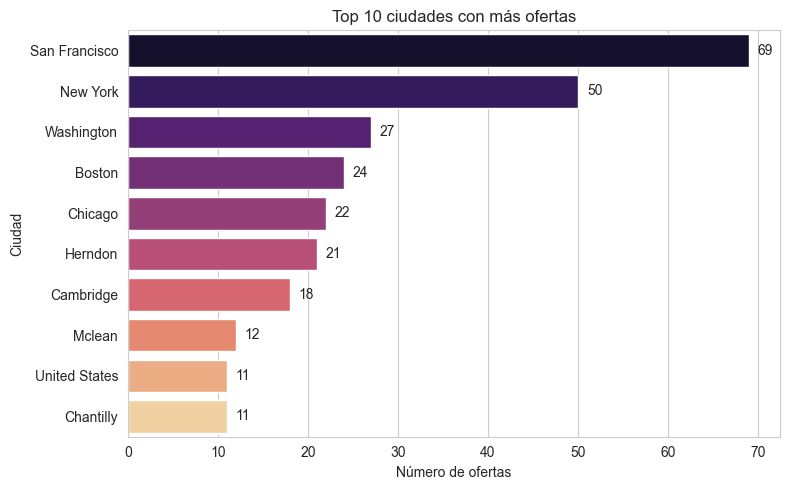

La ciudad con más ofertas es: 'San Francisco' — 69 ofertas.


In [48]:
loc_col = 'Location'  # asumimos que esta columna existe en el dataframe

# Comprobación rápida: si no existe, avisar (evita KeyError más adelante)
if loc_col not in df.columns:
    print(f"No existe la columna '{loc_col}' en el dataframe.")
else:
    # 1) Normalizar la columna a strings y eliminar nulos/espacios.
    #    Razonamiento: asegura que las operaciones de texto no fallen por tipos distintos
    loc_series = df[loc_col].astype(str).str.strip().replace({'nan': None}).dropna()

    if loc_series.empty:
        print("La columna de ubicación está vacía.")
    else:
        # 2) Extraer la ciudad. Muchas filas usan "City, State" -> tomar la parte antes de la primera coma.
        #    Razonamiento: simplifica y agrupa por ciudad (evitamos intentar parsear estados/países).
        cities = loc_series.str.split(',', n=1, expand=True)[0].str.strip().replace({'': None}).dropna()

        # 3) Normalizar nombres para agrupar variantes sencillas (todo a Title Case).
        #    Razonamiento: "madrid", "Madrid " y "MADRID" deben contarse igual.
        cities = cities.str.lower().str.title()

        # 4) Contar ocurrencias por ciudad y seleccionar el top_n.
        #    Razonamiento: value_counts es rápido y directo para este objetivo.
        top_n = 10
        city_counts = cities.value_counts()

        print(f"Top {min(top_n, len(city_counts))} ciudades con más ofertas:")
        display(city_counts.head(top_n).rename_axis('city').reset_index().rename(columns={0:'count'}))

        # 5) Visualización: barras horizontales con anotaciones.
        #    Razonamiento: facilita comparar rápidamente las ciudades más frecuentes.
        sns.set_style('whitegrid')
        plt.figure(figsize=(8, max(4, 0.5 * min(len(city_counts), top_n))))
        sns.barplot(x=city_counts.head(top_n).values, y=city_counts.head(top_n).index, palette='magma')
        plt.xlabel('Número de ofertas')
        plt.ylabel('Ciudad')
        plt.title(f'Top {min(top_n, len(city_counts))} ciudades con más ofertas')

        # Añadir anotaciones con el número exacto junto a cada barra (mejora la legibilidad)
        for i, v in enumerate(city_counts.head(top_n).values):
            plt.text(v + max(1, 0.01 * city_counts.max()), i, f"{int(v)}", va='center')

        plt.tight_layout()
        plt.show()

        # 6) Resultado claro: imprimir la ciudad con más ofertas.
        top_city = city_counts.idxmax()
        top_count = int(city_counts.max())
        print(f"La ciudad con más ofertas es: '{top_city}' — {top_count} ofertas.")


## 10. ¿Qué relación existe entre la antiguedad de la empresa y el salario que se ofrece? ¿En cuales se gana más?

Correlación Pearson entre antigüedad de la empresa y salario: -0.045
Top 10 edades de empresa por salario medio (se filtra por mínimo 5 ofertas cuando es posible):


,count,mean,median
company_age,,,
3,5,156.20,164.0
15,10,150.80,157.5
73,8,148.25,117.0
28,9,145.22,154.0
44,6,143.17,129.5
17,13,139.38,114.0
46,5,135.20,136.0
-1,118,134.67,123.0
18,6,132.67,124.5


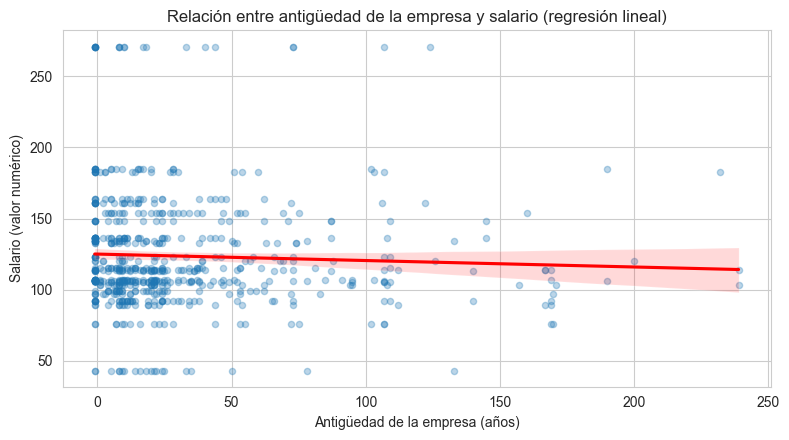

/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/3223121118.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top['mean'].values, y=top.index.astype(int).astype(str), palette='viridis')


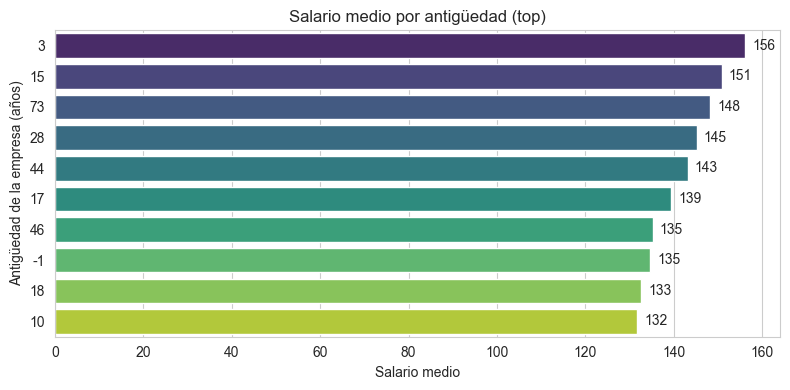

La antigüedad con mayor salario medio es 124 años — salario medio 271.00 (n=1).
Entre antigüedades con >= 5 ofertas la mejor es 3 años — salario medio 156.20 (n=5).


In [49]:
company_age_col = 'company_age'   # columna con antigüedad de la empresa (años)
# Preferimos avg_salary si existe; sino intentamos construirlo a partir de min/max
if 'avg_salary' in df.columns:
    salary = pd.to_numeric(df['avg_salary'], errors='coerce')
elif 'min_salary' in df.columns and 'max_salary' in df.columns:
    # usamos la media de min y max como aproximación
    min_s = pd.to_numeric(df['min_salary'], errors='coerce')
    max_s = pd.to_numeric(df['max_salary'], errors='coerce')
    salary = (min_s + max_s) / 2
    
# 1) Convertir antigüedad a numérico (puede contener NaN o cadenas)
company_age = pd.to_numeric(df[company_age_col], errors='coerce') if company_age_col in df.columns else pd.Series([np.nan] * len(df))

# 2) Juntar en un DataFrame temporal y eliminar filas con missing en las variables que nos interesan
temp = pd.DataFrame({'company_age': company_age, 'salary': salary})
temp = temp.dropna(subset=['company_age', 'salary'])

if temp.empty:
    print("No hay datos válidos de 'company_age' y salario para analizar.")
else:
    # 3) Correlación simple (Pearson) para dar una idea de la relación lineal
    corr = temp['company_age'].corr(temp['salary'])
    print(f"Correlación Pearson entre antigüedad de la empresa y salario: {corr:.3f}")

    # 4) Agrupar por antigüedad y calcular estadísticos (count, mean, median).
    #    Razonamiento: ver en qué edades de empresa se ofrecen salarios más altos.
    agg = temp.groupby('company_age')['salary'].agg(['count', 'mean', 'median']).sort_values('mean', ascending=False)

    # 5) Mostrar top N antigüedades por salario medio (filtrar por mínimo de ofertas para evitar ruido)
    min_count = 5
    top_n = 10
    agg_filtered = agg[agg['count'] >= min_count]
    top = agg_filtered.head(top_n) if not agg_filtered.empty else agg.head(top_n)
    print(f"Top {len(top)} edades de empresa por salario medio (se filtra por mínimo {min_count} ofertas cuando es posible):")
    display(top.round(2))

    # 6) Visualización 1: Scatter + línea de tendencia (muestra relación global)
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 4.5))
    sns.regplot(x='company_age', y='salary', data=temp, scatter_kws={'alpha':0.3, 's':20}, line_kws={'color':'red'})
    plt.xlabel('Antigüedad de la empresa (años)')
    plt.ylabel('Salario (valor numérico)')
    plt.title('Relación entre antigüedad de la empresa y salario (regresión lineal)')
    plt.tight_layout()
    plt.show()

    # 7) Visualización 2: barras del salario medio para las antigüedades más relevantes (las del 'top' calculado)
    if not top.empty:
        plt.figure(figsize=(8, max(3, 0.4 * len(top))))
        sns.barplot(x=top['mean'].values, y=top.index.astype(int).astype(str), palette='viridis')
        plt.xlabel('Salario medio')
        plt.ylabel('Antigüedad de la empresa (años)')
        plt.title('Salario medio por antigüedad (top)')
        for i, v in enumerate(top['mean'].values):
            plt.text(v + max(1, 0.01 * top['mean'].max()), i, f"{v:.0f}", va='center')
        plt.tight_layout()
        plt.show()

    # 8) Interpretación corta y resultado claro: ¿dónde se gana más según media?
    best = agg.iloc[0]
    print(f"La antigüedad con mayor salario medio es {agg.index[0]} años — salario medio {best['mean']:.2f} (n={int(best['count'])}).")
    if not agg_filtered.empty:
        best_filtered = agg_filtered.iloc[0]
        print(f"Entre antigüedades con >= {min_count} ofertas la mejor es {agg_filtered.index[0]} años — salario medio {best_filtered['mean']:.2f} (n={int(best_filtered['count'])}).")

# ...existing code...

## 11. Si eres un experto en python, ¿donde tendrias más posibilidades de encontrar trabajo?

Top 10 ciudades con más ofertas que requieren Python (conteo):


,city,count
0,San Francisco,63
1,New York,41
2,Herndon,20
3,Washington,19
4,Boston,18
5,Mclean,12
6,Chicago,12
7,Cambridge,10
8,United States,9
9,Santa Clara,8



Top 10 ciudades con mayor proporción de ofertas que requieren Python (solo ciudades con trabajos):


,city,count
0,Adelphi,100.0
1,Ann Arbor,100.0
2,Alpharetta,100.0
3,Annapolis Junction,100.0
4,Atlanta,100.0
5,Ashburn,100.0
6,Arlington,100.0
7,Gaithersburg,100.0
8,Germantown,100.0
9,Frederick,100.0


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/1606576385.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_py_counts.head(top_n).values, y=city_py_counts.head(top_n).index, ax=axes[0], palette='Blues_d')
/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/1606576385.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=(pct_python_by_city.head(top_n) * 100).values, y=pct_python_by_city.head(top_n).index, ax=axes[1], palette='Greens_d')


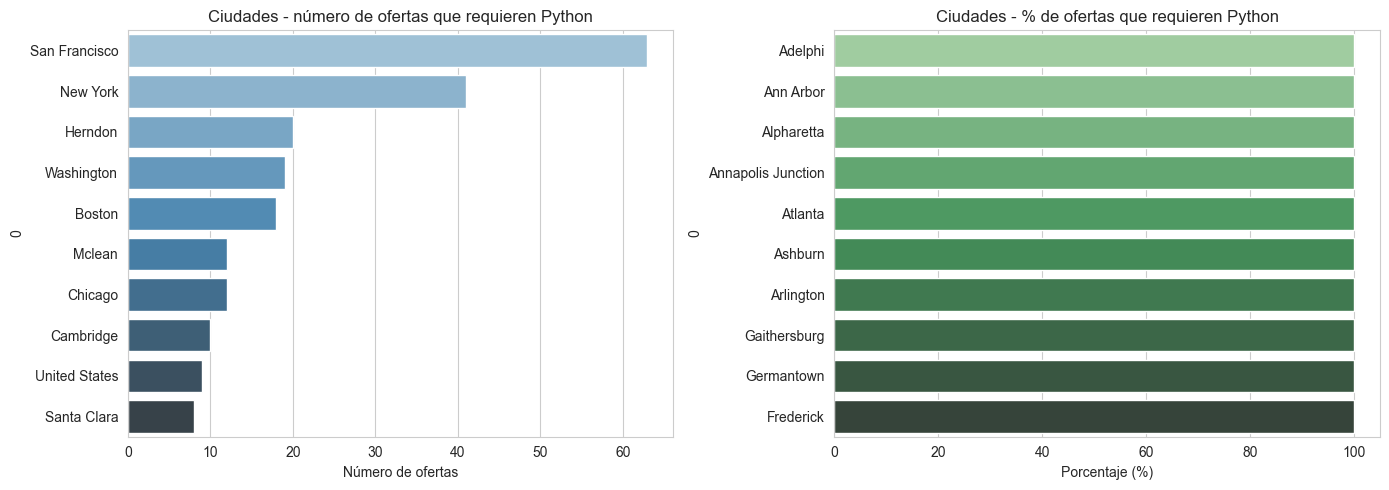

Más oportunidades absolutas (conteo): San Francisco — 63 ofertas que requieren Python.
Mayor probabilidad relativa (porcentaje): Adelphi — 100.0% de las ofertas en esa ciudad requieren Python.


In [50]:
# 1) Localizar columna 'python' (case-insensitive) y comprobar existencia
python_col = 'python'
loc_col = 'Location'  # asumimos que ya existe (como indicaste)


# 2) Normalizar la columna binaria python a 0/1 (evita valores tipo '1.0' o 'yes')
py_flag = pd.to_numeric(df[python_col], errors='coerce').fillna(0).astype(int)

# 3) Filtrar solo ofertas que requieren python
mask_py = py_flag == 1
if not mask_py.any():
    print("No se encontraron ofertas que requieran python (valor 1 en la columna).")
else:
    # 4) Extraer ciudad de la columna Location (misma lógica que el punto 9)
    def extract_city(series):
        s = series.astype(str).str.strip().replace({'nan': None}).dropna()
        cities = s.str.split(',', n=1, expand=True)[0].str.strip().replace({'': None}).dropna()
        return cities.str.lower().str.title()

    cities_py = extract_city(df.loc[mask_py, loc_col])
    cities_all = extract_city(df.loc[:, loc_col])  # para calcular proporciones por ciudad

    # 5) Contar ciudades donde hay ofertas con python
    city_py_counts = cities_py.value_counts()
    city_total_counts = cities_all.value_counts()

    # 6) Calcular porcentaje de ofertas en cada ciudad que requieren python
    #    (evita dividir por cero porque city_total_counts contiene solo ciudades existentes)
    pct_python_by_city = (city_py_counts / city_total_counts).fillna(0).sort_values(ascending=False)

    top_n = 10
    print(f"Top {min(top_n, len(city_py_counts))} ciudades con más ofertas que requieren Python (conteo):")
    display(city_py_counts.head(top_n).rename_axis('city').reset_index().rename(columns={0:'python_job_count'}))

    print(f"\nTop {min(top_n, len(pct_python_by_city))} ciudades con mayor proporción de ofertas que requieren Python (solo ciudades con trabajos):")
    display((pct_python_by_city.head(top_n) * 100).round(2).rename_axis('city').reset_index().rename(columns={0:'pct_jobs_require_python'}))

    # 7) Visualización: conteos y proporciones lado a lado para comparación
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if not city_py_counts.empty:
        sns.barplot(x=city_py_counts.head(top_n).values, y=city_py_counts.head(top_n).index, ax=axes[0], palette='Blues_d')
        axes[0].set_title('Ciudades - número de ofertas que requieren Python')
        axes[0].set_xlabel('Número de ofertas')
    if not pct_python_by_city.empty:
        sns.barplot(x=(pct_python_by_city.head(top_n) * 100).values, y=pct_python_by_city.head(top_n).index, ax=axes[1], palette='Greens_d')
        axes[1].set_title('Ciudades - % de ofertas que requieren Python')
        axes[1].set_xlabel('Porcentaje (%)')

    plt.tight_layout()
    plt.show()

    # 8) Resultado claro: mejor por conteo y mejor por proporción (útil para decidir estrategia)
    best_by_count = city_py_counts.idxmax() if not city_py_counts.empty else None
    best_by_count_n = int(city_py_counts.max()) if not city_py_counts.empty else 0

    best_by_pct = pct_python_by_city.idxmax() if not pct_python_by_city.empty else None
    best_by_pct_v = float(pct_python_by_city.max() * 100) if not pct_python_by_city.empty else 0.0

    if best_by_count:
        print(f"Más oportunidades absolutas (conteo): {best_by_count} — {best_by_count_n} ofertas que requieren Python.")
    if best_by_pct:
        print(f"Mayor probabilidad relativa (porcentaje): {best_by_pct} — {best_by_pct_v:.1f}% de las ofertas en esa ciudad requieren Python.")



## 12. Tras el anterior tema, os convertisteis unos expertos en tableau. ¿ En que ciudad ganarias más dinero por termino medio? Os gustaria trabajar ahi?

Top 10 ciudades por salario medio (filtrado por mínimo 5 ofertas cuando es posible):


,count,mean,median,std
city,,,,
Seattle,5,177.20,123.0,85.81
Washington,27,138.41,115.0,61.23
New York,50,136.52,120.0,48.41
Herndon,21,134.33,123.0,49.57
Reston,8,132.88,115.0,32.47
San Diego,7,127.86,115.0,23.61
Falls Church,5,126.60,134.0,27.94
Mclean,12,126.17,113.5,34.05
Redwood City,7,124.29,133.0,24.42


/var/folders/zx/57z_g0c14095702lbtyqdbx00000gn/T/ipykernel_40237/1479643996.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top['mean'].values, y=top.index, palette='magma')


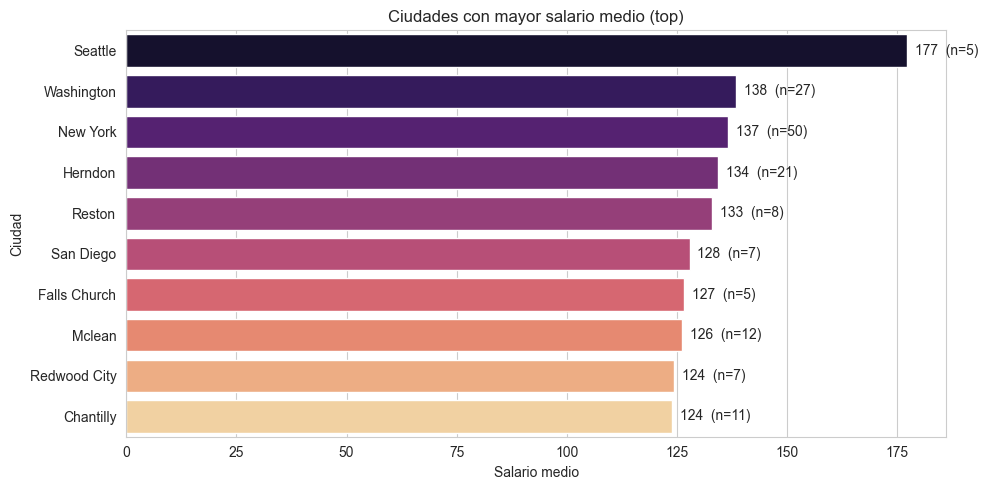

La ciudad con mayor salario medio (sin filtrar) es: Fort Sam Houston — salario medio 271.00 (n=1).
Entre ciudades con >= 5 ofertas, la mejor es: Seattle — salario medio 177.20 (n=5).
Un salario medio alto es relevante, pero conviene revisar también el número de ofertas (oportunidades) y el coste de vida local antes de decidir mudarse.
A título personal, me encanta la ciudad de Seattle así que no tendría problema en mudarme allí si el salario lo justifica.


In [51]:
# 1) Columnas usadas: ubicación y salario (priorizar avg_salary, sino min/max, sino intentar detectar columna de salario)
loc_col = 'Location'
if 'avg_salary' in df.columns:
    salary = pd.to_numeric(df['avg_salary'], errors='coerce')  # avg_salary ya limpia en celdas anteriores
elif 'min_salary' in df.columns and 'max_salary' in df.columns:
    # aproximamos salario por la media de min y max
    min_s = pd.to_numeric(df['min_salary'], errors='coerce')
    max_s = pd.to_numeric(df['max_salary'], errors='coerce')
    salary = (min_s + max_s) / 2
else:
    # intento heurístico: buscar cualquier columna con 'sal' o 'salary' en el nombre
    cand = [c for c in df.columns if any(k in c.lower() for k in ('sal','salary','salario','sueldo','pay'))]
    salary = pd.to_numeric(df[cand[0]], errors='coerce') if cand else pd.Series([np.nan]*len(df))
    # Razonamiento: preferimos columnas explícitas; si no hay ninguna, no podemos estimar salarios por ciudad.

# 2) Comprobar existencia de Location y preparar serie de ciudades
if loc_col not in df.columns:
    print(f"No existe la columna '{loc_col}' en el dataframe. Imposible agrupar por ciudad.")
else:
    # Normalizar y extraer ciudad (parte antes de la coma si hay formato "City, State")
    loc_series = df[loc_col].astype(str).str.strip().replace({'nan': None}).dropna()
    if loc_series.empty:
        print("La columna de ubicación está vacía.")
    else:
        cities = loc_series.str.split(',', n=1, expand=True)[0].str.strip().replace({'': None}).dropna()
        # Normalizar nombres: Title Case para agrupar variantes sencillas
        cities = cities.str.lower().str.title()

        # 3) Construir DataFrame temporal con ciudad y salario, y eliminar filas sin salario
        temp = pd.DataFrame({'city': cities, 'salary': salary.loc[cities.index]})
        temp = temp.dropna(subset=['salary', 'city'])

        if temp.empty:
            print("No hay datos de salario asignados a ciudades para analizar.")
        else:
            # 4) Agrupar por ciudad y calcular estadísticas relevantes
            agg = temp.groupby('city')['salary'].agg(['count', 'mean', 'median', 'std']).sort_values('mean', ascending=False)

            # 5) Filtrar por mínimo de ofertas para evitar outliers con muy pocas observaciones
            min_count = 5
            agg_filtered = agg[agg['count'] >= min_count]
            top_n = 10
            top = agg_filtered.head(top_n) if not agg_filtered.empty else agg.head(top_n)

            print(f"Top {len(top)} ciudades por salario medio (filtrado por mínimo {min_count} ofertas cuando es posible):")
            display(top.round(2))

            # 6) Visualización: barras horizontales del salario medio (anotando el número de ofertas)
            sns.set_style('whitegrid')
            plt.figure(figsize=(10, max(4, 0.5 * len(top))))
            ax = sns.barplot(x=top['mean'].values, y=top.index, palette='magma')
            ax.set_xlabel('Salario medio')
            ax.set_ylabel('Ciudad')
            ax.set_title('Ciudades con mayor salario medio (top)')

            # Anotar salario medio y número de ofertas en cada barra
            for i, (city, row) in enumerate(top.iterrows()):
                ax.text(row['mean'] + max(1, 0.01 * top['mean'].max()), i,
                        f"{row['mean']:.0f}  (n={int(row['count'])})", va='center')

            plt.tight_layout()
            plt.show()

            # 7) Resultado claro y consejo breve
            best_overall = agg.iloc[0]
            best_city_overall = agg.index[0]
            print(f"La ciudad con mayor salario medio (sin filtrar) es: {best_city_overall} — salario medio {best_overall['mean']:.2f} (n={int(best_overall['count'])}).")

            if not agg_filtered.empty:
                best_filtered = agg_filtered.iloc[0]
                best_city_filtered = agg_filtered.index[0]
                print(f"Entre ciudades con >= {min_count} ofertas, la mejor es: {best_city_filtered} — salario medio {best_filtered['mean']:.2f} (n={int(best_filtered['count'])}).")

            # Nota interpretativa corta (objetiva): elegir trabajar en esa ciudad depende también de número de ofertas y coste de vida.
            print("Un salario medio alto es relevante, pero conviene revisar también el número de ofertas (oportunidades) y el coste de vida local antes de decidir mudarse.")
            print("A título personal, me encanta la ciudad de Seattle así que no tendría problema en mudarme allí si el salario lo justifica.")



In [ ]:
# Convertir a HTML incluyendo outputs ejecutados
!jupyter nbconvert "seaborn_student_lab - versiÃ³n alumno.ipynb" --to html --execute --output "analisis_completo.html"

print("✅ Notebook convertido a HTML exitosamente")

[NbConvertApp] Converting notebook seaborn_student_lab - versiÃ³n alumno.ipynb to html
